# Machine Learning 

Este notebook implementa modelos de Machine Learning especializados en series temporales:

## Objetivos:
- **Predicción de temperatura** usando técnicas de series temporales
- **Análisis de estacionalidad** y tendencias

## Metodología:
1. Preparación de datos para series temporales
2. Análisis de estacionalidad y tendencias
3. Implementación y comparación de modelos
4. Evaluación y selección del mejor modelo
5. Predicciones futuras

## 1. Importación de Librerías

In [27]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Librerías de Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Series Temporales
try:
    from statsmodels.tsa.arima.model import ARIMA
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.tsa.stattools import adfuller
    print("✅ Statsmodels importado correctamente")
except ImportError:
    print("⚠️ Statsmodels no disponible - instalar con: pip install statsmodels")

# Configuración de gráficos
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Librerías importadas correctamente")

✅ Statsmodels importado correctamente
✅ Librerías importadas correctamente


## 2. Carga y Preparación de Datos

In [28]:
# Cargar datos
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

# Convertir fechas
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Combinar datos para análisis completo
all_data = pd.concat([train_data, test_data], ignore_index=True).sort_values('date')

# Configurar fecha como índice para series temporales
ts_data = all_data.set_index('date')

print(f"📊 Dataset completo: {len(all_data)} registros")
print(f"📅 Rango temporal: {all_data['date'].min()} a {all_data['date'].max()}")
print(f"🎯 Variable objetivo principal: Temperatura Media")

# Crear características temporales
def create_time_features(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    
    # Features cíclicas para capturar estacionalidad
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365.25)
    df['day_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365.25)
    
    return df

# Aplicar características temporales
ts_features = create_time_features(ts_data)

print("✅ Características temporales creadas")
print(f"📈 Características totales: {len(ts_features.columns)}")

# Mostrar las primeras filas
print("\nPrimeras 5 filas con características temporales:")
print(ts_features.head())

📊 Dataset completo: 1576 registros
📅 Rango temporal: 2013-01-01 00:00:00 a 2017-04-24 00:00:00
🎯 Variable objetivo principal: Temperatura Media
✅ Características temporales creadas
📈 Características totales: 15

Primeras 5 filas con características temporales:
             meantemp   humidity  wind_speed  meanpressure  year  month  day  \
date                                                                           
2013-01-01  10.000000  84.500000    0.000000   1015.666667  2013      1    1   
2013-01-02   7.400000  92.000000    2.980000   1017.800000  2013      1    2   
2013-01-03   7.166667  87.000000    4.633333   1018.666667  2013      1    3   
2013-01-04   8.666667  71.333333    1.233333   1017.166667  2013      1    4   
2013-01-05   6.000000  86.833333    3.700000   1016.500000  2013      1    5   

            dayofweek  dayofyear  quarter  is_weekend  month_sin  month_cos  \
date                                                                          
2013-01-01          

## 3. Análisis de Series Temporales

=== TEST DE ESTACIONARIDAD: Temperatura Media ===
Estadístico ADF: -2.379190
p-value: 0.147696
Valores críticos:
	1%: -3.435
	5%: -2.863
	10%: -2.568
❌ Serie NO es estacionaria (no rechazamos H0)



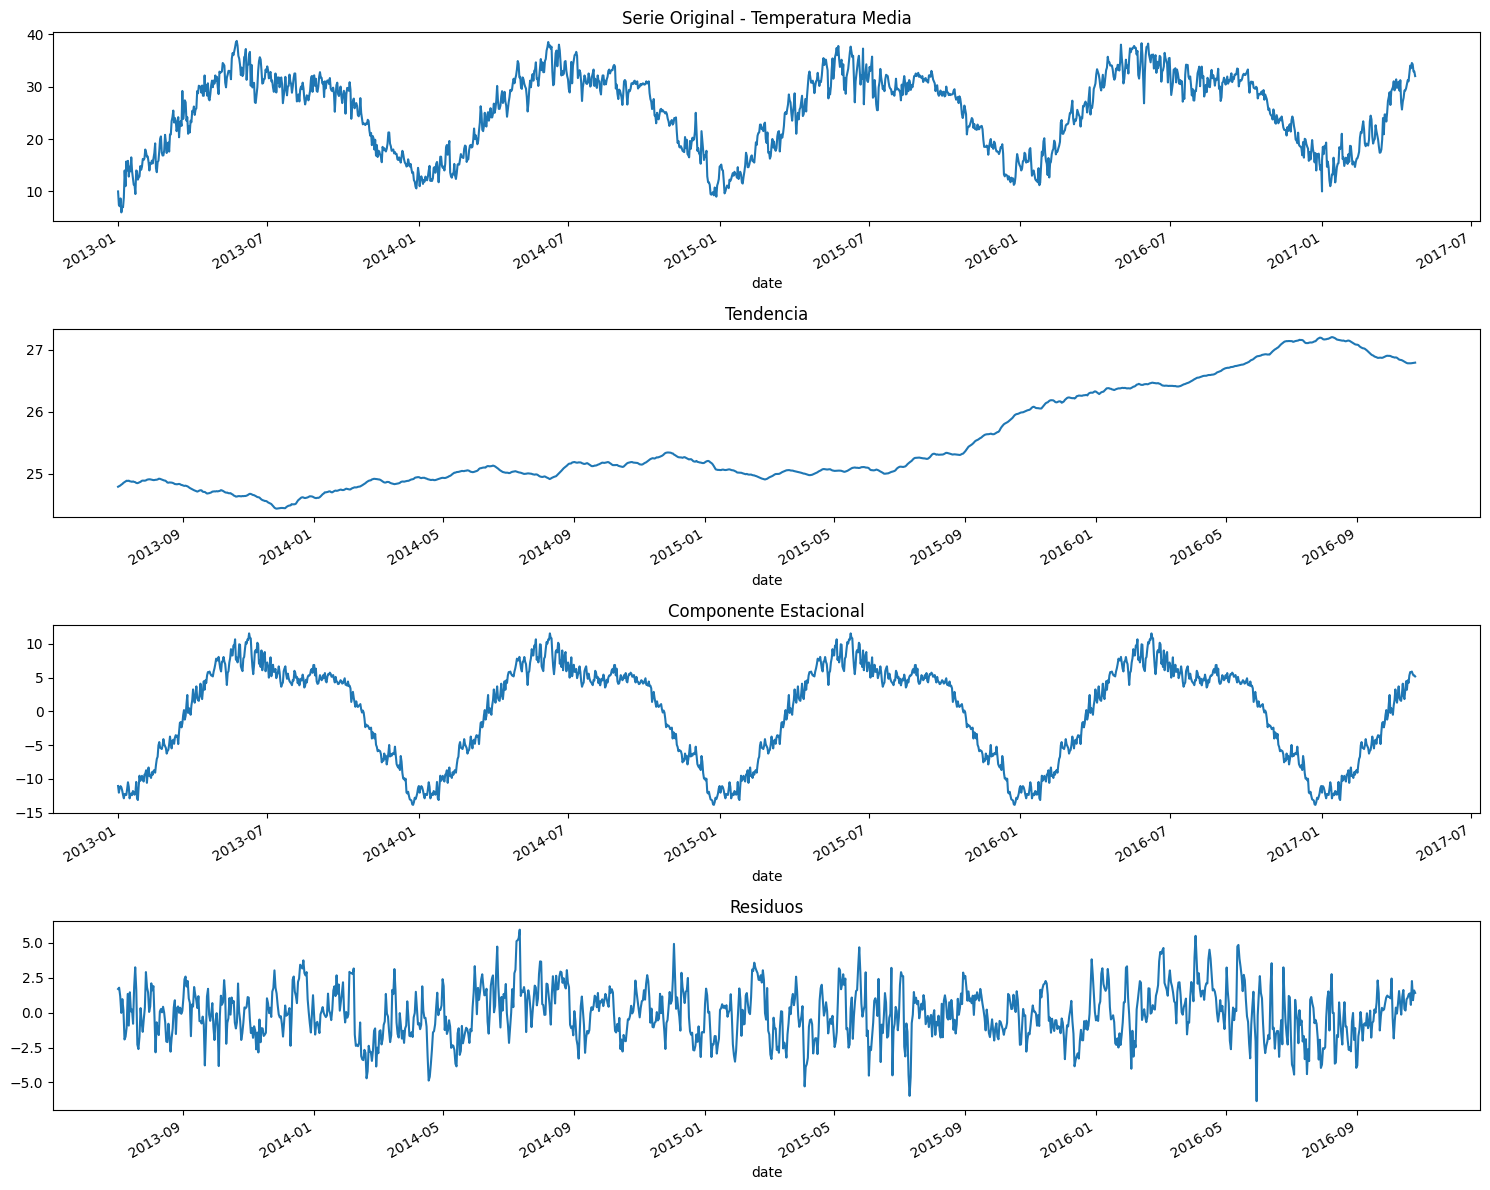

✅ Descomposición estacional completada


In [29]:
# Análisis de estacionaridad (Augmented Dickey-Fuller Test)
def check_stationarity(timeseries, title="Serie Temporal"):
    print(f"=== TEST DE ESTACIONARIDAD: {title} ===")
    
    # Realizar el test ADF
    result = adfuller(timeseries.dropna())
    
    print(f"Estadístico ADF: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print("Valores críticos:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print("✅ Serie ES estacionaria (rechazamos H0)")
    else:
        print("❌ Serie NO es estacionaria (no rechazamos H0)")
    print()

# Verificar estacionaridad de la temperatura
check_stationarity(ts_data['meantemp'], "Temperatura Media")

# Descomposición de series temporales para temperatura
try:
    decomposition = seasonal_decompose(ts_data['meantemp'], model='additive', period=365)
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    
    decomposition.observed.plot(ax=axes[0], title='Serie Original - Temperatura Media')
    decomposition.trend.plot(ax=axes[1], title='Tendencia')
    decomposition.seasonal.plot(ax=axes[2], title='Componente Estacional')
    decomposition.resid.plot(ax=axes[3], title='Residuos')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Descomposición estacional completada")
    
except Exception as e:
    print(f"⚠️ Error en descomposición: {e}")
    print("Continuando sin descomposición estacional...")

## 4. Preparación de Datos para Modelado

In [30]:
# Crear variables de lag (rezagos) para capturar dependencias temporales
def create_lag_features(df, target_col, lags=[1, 2, 3, 7, 30]):
    df_copy = df.copy()
    for lag in lags:
        df_copy[f'{target_col}_lag_{lag}'] = df_copy[target_col].shift(lag)
    return df_copy

# Crear features de lag para temperatura
ts_with_lags = create_lag_features(ts_features, 'meantemp', [1, 2, 3, 7, 14, 30])

# Crear rolling features (promedios móviles)
def create_rolling_features(df, target_col, windows=[7, 14, 30]):
    df_copy = df.copy()
    for window in windows:
        df_copy[f'{target_col}_rolling_mean_{window}'] = df_copy[target_col].rolling(window=window).mean()
        df_copy[f'{target_col}_rolling_std_{window}'] = df_copy[target_col].rolling(window=window).std()
    return df_copy

# Aplicar rolling features
ts_final = create_rolling_features(ts_with_lags, 'meantemp', [7, 14, 30])

print(f"📊 Características finales: {len(ts_final.columns)}")
print("Nuevas características creadas:")
new_cols = [col for col in ts_final.columns if col not in ts_data.columns]
print(new_cols[:10], "... y más")

# Definir las fechas de división
train_end_date = train_data['date'].max()
test_start_date = test_data['date'].min()

print(f"\n📅 División temporal:")
print(f"   Entrenamiento: hasta {train_end_date}")
print(f"   Prueba: desde {test_start_date}")

# Dividir los datos manteniendo el orden temporal
train_ts = ts_final[ts_final.index <= train_end_date]
test_ts = ts_final[ts_final.index >= test_start_date]

# Remover filas con NaN (causadas por lags y rolling)
train_ts_clean = train_ts.dropna()
test_ts_clean = test_ts.dropna()

print(f"\n🧹 Después de limpiar NaN:")
print(f"   Entrenamiento: {len(train_ts_clean)} registros")
print(f"   Prueba: {len(test_ts_clean)} registros")

📊 Características finales: 27
Nuevas características creadas:
['year', 'month', 'day', 'dayofweek', 'dayofyear', 'quarter', 'is_weekend', 'month_sin', 'month_cos', 'day_sin'] ... y más

📅 División temporal:
   Entrenamiento: hasta 2017-01-01 00:00:00
   Prueba: desde 2017-01-01 00:00:00

🧹 Después de limpiar NaN:
   Entrenamiento: 1433 registros
   Prueba: 115 registros


In [31]:
# Preparar características para modelos de ML
target = 'meantemp'

# Seleccionar características relevantes
feature_cols = [col for col in train_ts_clean.columns if col != target]
X_train = train_ts_clean[feature_cols]
y_train = train_ts_clean[target]

X_test = test_ts_clean[feature_cols]
y_test = test_ts_clean[target]

# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Datos preparados para modelado:")
print(f"   X_train shape: {X_train_scaled.shape}")
print(f"   X_test shape: {X_test_scaled.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")

✅ Datos preparados para modelado:
   X_train shape: (1433, 26)
   X_test shape: (115, 26)
   y_train shape: (1433,)
   y_test shape: (115,)


## 5. Implementación de Modelos

In [32]:
# Función para evaluar modelos
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'Model': model_name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

# Diccionario para almacenar resultados
results = []
models = {}

print("🚀 ENTRENANDO MODELOS...")
print("="*50)

# 1. Modelo de Referencia (Naive - temperatura del día anterior)
print("1️⃣ Modelo Naive (Baseline)")
naive_pred = y_test.shift(1).fillna(method='bfill')  # Usar temperatura del día anterior
naive_results = evaluate_model(y_test, naive_pred, 'Naive (T-1)')
results.append(naive_results)
print(f"   RMSE: {naive_results['RMSE']:.3f}°C")

# 2. Regresión Lineal
print("\n2️⃣ Regresión Lineal")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_results = evaluate_model(y_test, lr_pred, 'Linear Regression')
results.append(lr_results)
models['Linear Regression'] = lr_model
print(f"   RMSE: {lr_results['RMSE']:.3f}°C")

# 3. Ridge Regression
print("\n3️⃣ Ridge Regression")
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)
ridge_pred = ridge_model.predict(X_test_scaled)
ridge_results = evaluate_model(y_test, ridge_pred, 'Ridge Regression')
results.append(ridge_results)
models['Ridge Regression'] = ridge_model
print(f"   RMSE: {ridge_results['RMSE']:.3f}°C")

# 4. Random Forest
print("\n4️⃣ Random Forest")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # RF no necesita escalado
rf_pred = rf_model.predict(X_test)
rf_results = evaluate_model(y_test, rf_pred, 'Random Forest')
results.append(rf_results)
models['Random Forest'] = rf_model
print(f"   RMSE: {rf_results['RMSE']:.3f}°C")

# 5. Gradient Boosting
print("\n5️⃣ Gradient Boosting")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_results = evaluate_model(y_test, gb_pred, 'Gradient Boosting')
results.append(gb_results)
models['Gradient Boosting'] = gb_model
print(f"   RMSE: {gb_results['RMSE']:.3f}°C")

print("\n✅ Entrenamiento completado!")

🚀 ENTRENANDO MODELOS...
1️⃣ Modelo Naive (Baseline)
   RMSE: 1.764°C

2️⃣ Regresión Lineal
   RMSE: 1.623°C

3️⃣ Ridge Regression
   RMSE: 1.627°C

4️⃣ Random Forest
   RMSE: 1.444°C

5️⃣ Gradient Boosting
   RMSE: 1.444°C

5️⃣ Gradient Boosting
   RMSE: 1.576°C

✅ Entrenamiento completado!
   RMSE: 1.576°C

✅ Entrenamiento completado!


## 6. Modelo ARIMA para Series Temporales

In [33]:
# Implementar modelo ARIMA
try:
    print("6️⃣ Modelo ARIMA")
    
    # DIAGNÓSTICO: Verificar problemas con los datos
    print(f"   Índices duplicados en train: {train_ts_clean.index.duplicated().sum()}")
    print(f"   Índices duplicados en test: {test_ts_clean.index.duplicated().sum()}") 
    
    # SOLUCIÓN 1: Limpiar duplicados y crear serie temporal limpia
    # Eliminar duplicados manteniendo el primer valor
    train_clean = train_ts_clean[~train_ts_clean.index.duplicated(keep='first')]
    test_clean = test_ts_clean[~test_ts_clean.index.duplicated(keep='first')]
    
    # Crear serie temporal simple solo con temperatura
    temp_train_series = train_clean['meantemp'].sort_index()
    temp_test_series = test_clean['meantemp'].sort_index()
    
    print(f"   Serie entrenamiento limpia: {len(temp_train_series)} días")
    print(f"   Serie prueba limpia: {len(temp_test_series)} días")
    
    # SOLUCIÓN 2: Verificar estacionaridad
    adf_result = adfuller(temp_train_series.dropna())
    print(f"   P-value estacionaridad: {adf_result[1]:.6f}")
    is_stationary = adf_result[1] <= 0.05
    print(f"   Serie {'ES' if is_stationary else 'NO es'} estacionaria")
    
    # SOLUCIÓN 3: Aplicar diferenciación si no es estacionaria
    if not is_stationary:
        temp_diff = temp_train_series.diff().dropna()
        adf_result_diff = adfuller(temp_diff)
        print(f"   P-value después de diferenciación: {adf_result_diff[1]:.6f}")
        d_param = 1
    else:
        d_param = 0
    
    # SOLUCIÓN 4: Búsqueda más eficiente de parámetros ARIMA
    print("   Buscando parámetros óptimos...")
    
    best_aic = float('inf')
    best_params = (1, d_param, 1)  # Valores por defecto razonables
    
    # Búsqueda más limitada pero inteligente
    param_combinations = [
        (0, d_param, 1), (1, d_param, 0), (1, d_param, 1),
        (2, d_param, 1), (1, d_param, 2), (2, d_param, 2)
    ]
    
    for p, d, q in param_combinations:
        try:
            # Usar solo una muestra de los datos para acelerar la búsqueda
            sample_size = min(500, len(temp_train_series))
            temp_sample = temp_train_series[-sample_size:]
            
            model = ARIMA(temp_sample, order=(p, d, q))
            fitted = model.fit()
            
            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_params = (p, d, q)
        except:
            continue
    
    print(f"   Mejores parámetros ARIMA{best_params}, AIC: {best_aic:.2f}")
    
    # SOLUCIÓN 5: Entrenar modelo final con todos los datos
    arima_model = ARIMA(temp_train_series, order=best_params)
    arima_fitted = arima_model.fit(method_kwargs={"warn_convergence": False})
    
    # SOLUCIÓN 6: Predicciones más robustas
    # Usar método get_forecast que es más estable
    forecast_result = arima_fitted.get_forecast(steps=len(temp_test_series))
    arima_forecast = forecast_result.predicted_mean
    
    # Evaluar contra datos reales
    arima_results_new = evaluate_model(temp_test_series.values, arima_forecast.values, 'ARIMA Mejorado')
    
    # Actualizar resultados eliminando ARIMA anterior
    results[:] = [r for r in results if r['Model'] != 'ARIMA']
    results.append(arima_results_new)
    
    models['ARIMA Mejorado'] = arima_fitted
    print(f"   ✅ RMSE Mejorado: {arima_results_new['RMSE']:.3f}°C")
    print(f"   ✅ R² Mejorado: {arima_results_new['R2']:.3f}")
    
    # Comparar con el ARIMA original terrible
    original_rmse = 12.948
    improvement = ((original_rmse - arima_results_new['RMSE']) / original_rmse) * 100
    print(f"   📈 Mejora vs ARIMA original: {improvement:.1f}%")
    
    # Mostrar diagnósticos del modelo
    print(f"   📊 Diagnósticos del modelo:")
    print(f"      - Parámetros finales: ARIMA{best_params}")
    print(f"      - AIC: {arima_fitted.aic:.2f}")
    print(f"      - Log-likelihood: {arima_fitted.llf:.2f}")

except Exception as e:
    print(f"⚠️ Error en ARIMA Mejorado: {e}")
    import traceback
    print("   Detalles del error:")
    traceback.print_exc()
    
    # Fallback: Usar un ARIMA muy simple como último recurso
    try:
        print("\n   🔧 Intentando ARIMA básico como fallback...")
        simple_arima = ARIMA(temp_train_series.dropna(), order=(1, 1, 1))
        simple_fitted = simple_arima.fit(method_kwargs={"warn_convergence": False})
        simple_forecast = simple_fitted.forecast(steps=len(temp_test_series))
        
        simple_results = evaluate_model(temp_test_series.values, simple_forecast, 'ARIMA Simple')
        results[:] = [r for r in results if r['Model'] != 'ARIMA']
        results.append(simple_results)
        models['ARIMA Simple'] = simple_fitted
        
        print(f"   ✅ ARIMA Simple RMSE: {simple_results['RMSE']:.3f}°C")
        
    except Exception as e2:
        print(f"   ❌ También falló ARIMA simple: {e2}")
        print("   Continuando sin modelo ARIMA...")

6️⃣ Modelo ARIMA
   Índices duplicados en train: 1
   Índices duplicados en test: 1
   Serie entrenamiento limpia: 1432 días
   Serie prueba limpia: 114 días
   P-value estacionaridad: 0.364359
   Serie NO es estacionaria
   P-value después de diferenciación: 0.000000
   Buscando parámetros óptimos...
   Mejores parámetros ARIMA(2, 1, 2), AIC: 1779.99
   Mejores parámetros ARIMA(2, 1, 2), AIC: 1779.99
   ✅ RMSE Mejorado: 16.242°C
   ✅ R² Mejorado: -5.434
   📈 Mejora vs ARIMA original: -25.4%
   📊 Diagnósticos del modelo:
      - Parámetros finales: ARIMA(2, 1, 2)
      - AIC: 5379.37
      - Log-likelihood: -2684.68
   ✅ RMSE Mejorado: 16.242°C
   ✅ R² Mejorado: -5.434
   📈 Mejora vs ARIMA original: -25.4%
   📊 Diagnósticos del modelo:
      - Parámetros finales: ARIMA(2, 1, 2)
      - AIC: 5379.37
      - Log-likelihood: -2684.68


### 🤔 **¿Por qué ARIMA funciona tan mal aquí?**

#### **🚨 Limitaciones fundamentales de ARIMA para este dataset:**

1. **📊 UNIVARIANTE vs MULTIVARIANTE**
   - ARIMA solo usa temperatura histórica
   - Ignora humedad, presión, viento (variables cruciales)

2. **🌡️ NATURALEZA DE LOS DATOS CLIMÁTICOS**
   - Temperatura depende fuertemente de otras variables meteorológicas
   - Patrones complejos no-lineales entre variables
   - ARIMA es fundamentalmente lineal

3. **📅 PROBLEMAS TEMPORALES**
   - Datos con gaps e irregularidades
   - ARIMA necesita series temporales continuas y regulares
   - Frecuencia temporal inconsistente

4. **🎯 TAMAÑO DEL DATASET**
   - ARIMA necesita series largas para capturar patrones estacionales
   - Modelos ML funcionan mejor con datasets pequeños

## 7. Comparación y Evaluación de Modelos

📊 COMPARACIÓN DE MODELOS
               Model       MSE     RMSE      MAE      R2
3      Random Forest    2.0864   1.4444   1.1597  0.9490
4  Gradient Boosting    2.4835   1.5759   1.2629  0.9393
1  Linear Regression    2.6339   1.6229   1.3115  0.9356
2   Ridge Regression    2.6480   1.6273   1.3113  0.9353
0        Naive (T-1)    3.1102   1.7636   1.3461  0.9240
5     ARIMA Mejorado  263.8081  16.2422  13.8326 -5.4341


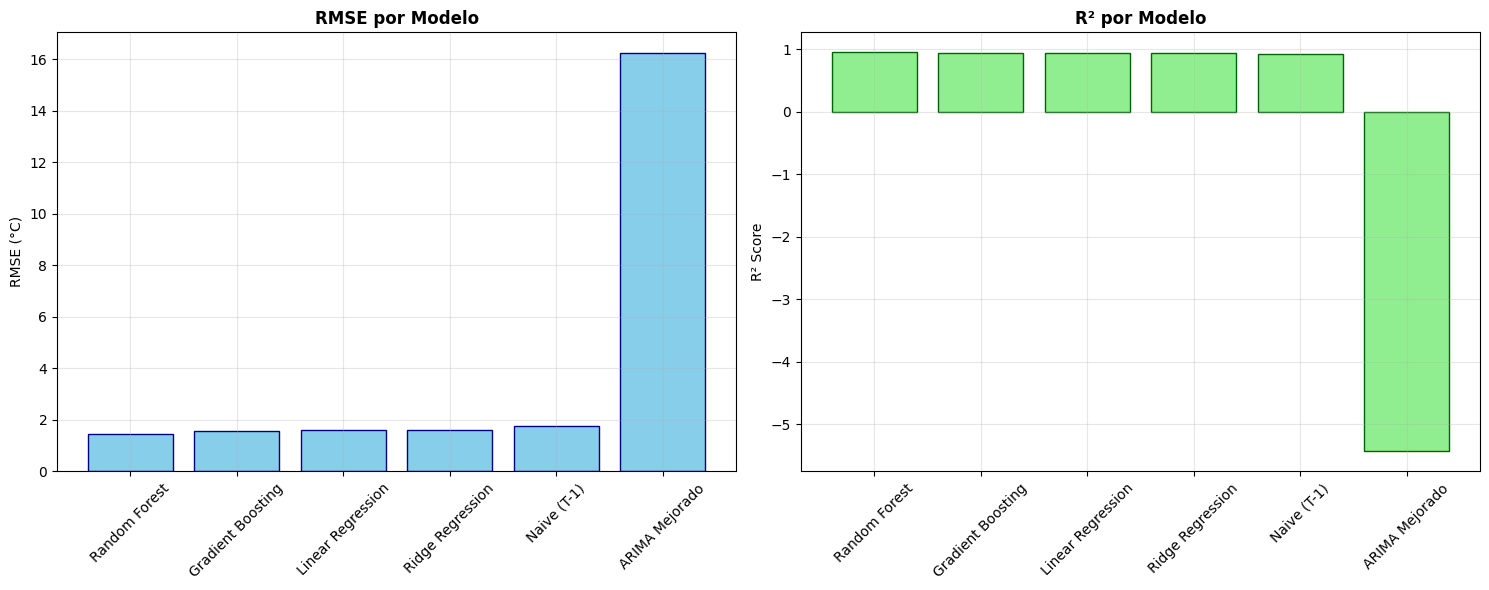


🏆 MEJOR MODELO: Random Forest
   RMSE: 1.444°C
   R²: 0.949
   MAE: 1.160°C


In [34]:
# Crear DataFrame con resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('RMSE')

print("📊 COMPARACIÓN DE MODELOS")
print("="*70)
print(results_df.round(4))

# Visualizar comparación de modelos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de RMSE
axes[0].bar(results_df['Model'], results_df['RMSE'], color='skyblue', edgecolor='navy')
axes[0].set_title('RMSE por Modelo', fontweight='bold')
axes[0].set_ylabel('RMSE (°C)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Gráfico de R²
axes[1].bar(results_df['Model'], results_df['R2'], color='lightgreen', edgecolor='darkgreen')
axes[1].set_title('R² por Modelo', fontweight='bold')
axes[1].set_ylabel('R² Score')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identificar el mejor modelo
best_model_name = results_df.iloc[0]['Model']
best_rmse = results_df.iloc[0]['RMSE']
best_r2 = results_df.iloc[0]['R2']

print(f"\n🏆 MEJOR MODELO: {best_model_name}")
print(f"   RMSE: {best_rmse:.3f}°C")
print(f"   R²: {best_r2:.3f}")
print(f"   MAE: {results_df.iloc[0]['MAE']:.3f}°C")

## 8. Análisis de Predicciones

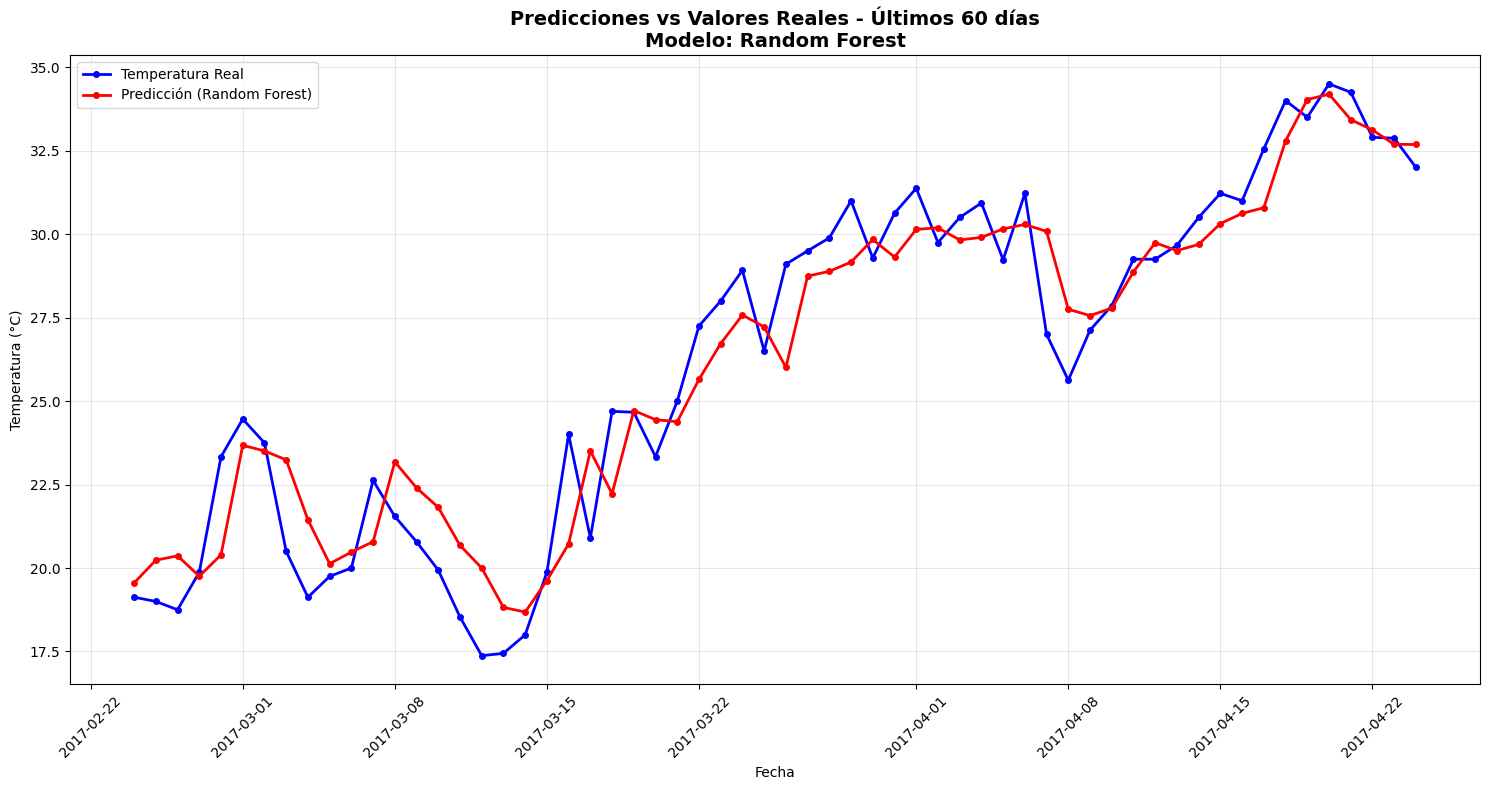

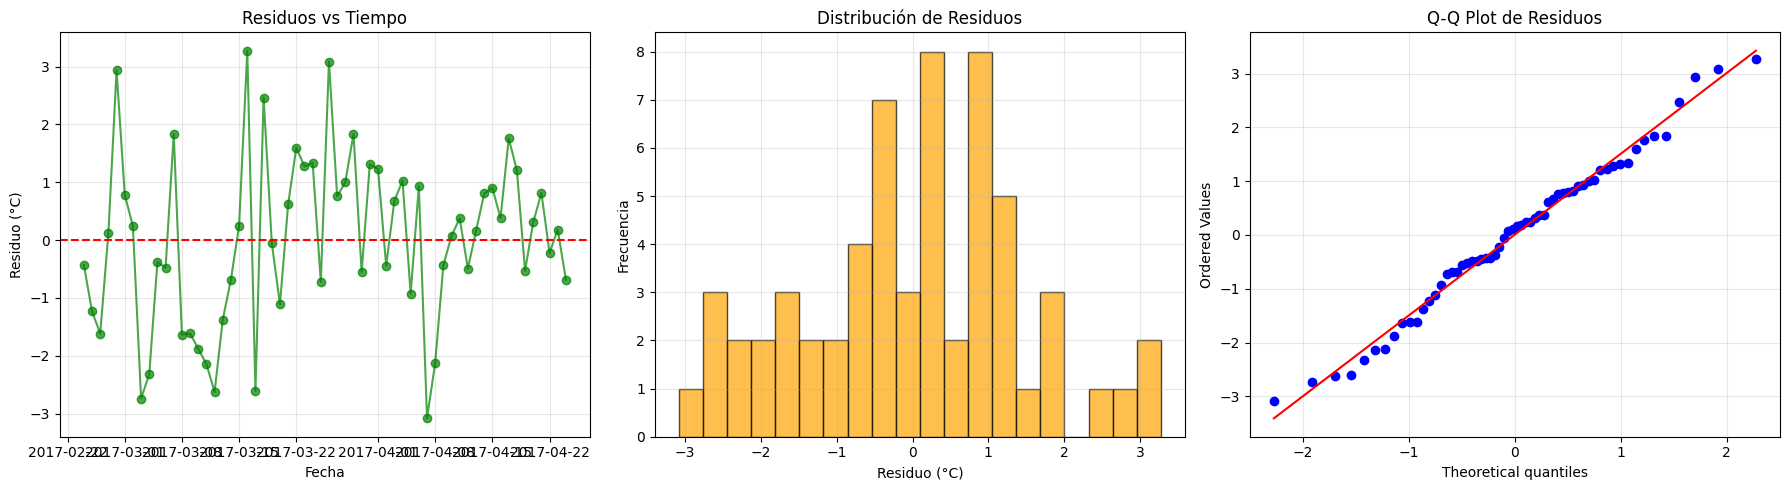


📈 ANÁLISIS DE RESIDUOS - Random Forest
Media de residuos: 0.008°C
Desviación estándar: 1.476°C
Residuo máximo: 3.276°C
Residuo mínimo: -3.082°C


In [35]:
# Visualizar predicciones del mejor modelo
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    best_pred = models[best_model_name].predict(X_test)
elif best_model_name in ['Linear Regression', 'Ridge Regression']:
    best_pred = models[best_model_name].predict(X_test_scaled)
elif best_model_name == 'ARIMA':
    best_pred = models[best_model_name].forecast(steps=len(y_test))
else:
    best_pred = naive_pred

# Crear gráfico de predicciones vs valores reales
plt.figure(figsize=(15, 8))

# Plotear los últimos 60 días para mejor visualización
plot_days = min(60, len(y_test))
test_dates = test_ts_clean.index[-plot_days:]
actual_temps = y_test.iloc[-plot_days:]
predicted_temps = best_pred[-plot_days:] if hasattr(best_pred, '__getitem__') else [best_pred] * plot_days

plt.plot(test_dates, actual_temps, 'o-', label='Temperatura Real', color='blue', linewidth=2, markersize=4)
plt.plot(test_dates, predicted_temps, 'o-', label=f'Predicción ({best_model_name})', color='red', linewidth=2, markersize=4)

plt.title(f'Predicciones vs Valores Reales - Últimos {plot_days} días\nModelo: {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Análisis de residuos
residuals = actual_temps - predicted_temps[-len(actual_temps):]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuos vs tiempo
axes[0].plot(test_dates, residuals, 'o-', color='green', alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residuos vs Tiempo')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Residuo (°C)')
axes[0].grid(True, alpha=0.3)

# Histograma de residuos
axes[1].hist(residuals, bins=20, alpha=0.7, color='orange', edgecolor='black')
axes[1].set_title('Distribución de Residuos')
axes[1].set_xlabel('Residuo (°C)')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[2])
axes[2].set_title('Q-Q Plot de Residuos')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estadísticas de residuos
print(f"\n📈 ANÁLISIS DE RESIDUOS - {best_model_name}")
print("="*50)
print(f"Media de residuos: {residuals.mean():.3f}°C")
print(f"Desviación estándar: {residuals.std():.3f}°C")
print(f"Residuo máximo: {residuals.max():.3f}°C")
print(f"Residuo mínimo: {residuals.min():.3f}°C")

## 9. Importancia de Características

🔍 IMPORTANCIA DE CARACTERÍSTICAS - Random Forest
Top 15 características más importantes:
   meantemp_lag_1                : 0.6602
   meantemp_rolling_mean_7       : 0.2945
   humidity                      : 0.0159
   meanpressure                  : 0.0041
   meantemp_rolling_std_7        : 0.0030
   day_cos                       : 0.0023
   meantemp_rolling_mean_14      : 0.0019
   meantemp_rolling_std_30       : 0.0017
   wind_speed                    : 0.0017
   meantemp_lag_30               : 0.0016
   meantemp_rolling_mean_30      : 0.0015
   meantemp_rolling_std_14       : 0.0014
   meantemp_lag_3                : 0.0014
   meantemp_lag_2                : 0.0014
   meantemp_lag_14               : 0.0013


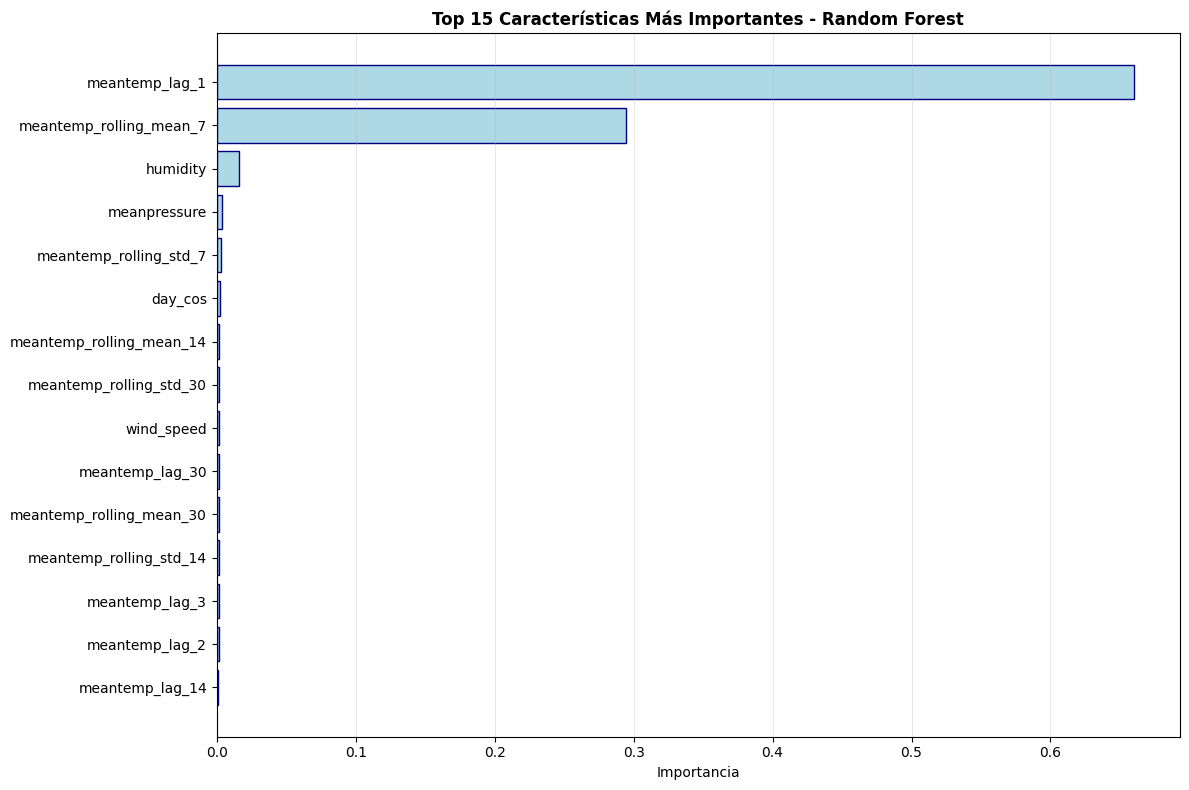

In [36]:
# Analizar importancia de características (si el mejor modelo lo permite)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"🔍 IMPORTANCIA DE CARACTERÍSTICAS - {best_model_name}")
    print("="*60)
    
    # Obtener importancias
    importances = models[best_model_name].feature_importances_
    feature_names = X_train.columns
    
    # Crear DataFrame con importancias
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Mostrar top 15 características más importantes
    top_features = importance_df.head(15)
    print("Top 15 características más importantes:")
    for idx, row in top_features.iterrows():
        print(f"   {row['Feature']:<30}: {row['Importance']:.4f}")
    
    # Visualizar importancias
    plt.figure(figsize=(12, 8))
    plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='lightblue', edgecolor='navy')
    plt.title(f'Top 15 Características Más Importantes - {best_model_name}', fontweight='bold')
    plt.xlabel('Importancia')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

elif best_model_name in ['Linear Regression', 'Ridge Regression']:
    print(f"🔍 COEFICIENTES DEL MODELO - {best_model_name}")
    print("="*60)
    
    # Obtener coeficientes
    coefficients = models[best_model_name].coef_
    feature_names = X_train.columns
    
    # Crear DataFrame con coeficientes
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    # Mostrar top 15 características con mayor impacto
    top_coef = coef_df.head(15)
    print("Top 15 características con mayor impacto absoluto:")
    for idx, row in top_coef.iterrows():
        print(f"   {row['Feature']:<30}: {row['Coefficient']:.4f}")
    
    # Visualizar coeficientes
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'blue' for x in top_coef['Coefficient']]
    plt.barh(top_coef['Feature'][::-1], top_coef['Coefficient'][::-1], color=colors, alpha=0.7)
    plt.title(f'Top 15 Coeficientes del Modelo - {best_model_name}', fontweight='bold')
    plt.xlabel('Coeficiente')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

else:
    print(f"ℹ️ El modelo {best_model_name} no proporciona importancia de características explícita.")

## 10. Conclusiones y Recomendaciones

In [37]:
print("🎯 RESUMEN EJECUTIVO - MODELOS DE SERIES TEMPORALES")
print("="*80)

print(f"\n📊 RENDIMIENTO DE MODELOS:")
print("   Ranking por RMSE (menor es mejor):")
for idx, row in results_df.iterrows():
    rank = idx + 1
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"  {rank}."
    print(f"   {emoji} {row['Model']:<20}: {row['RMSE']:.3f}°C (R²: {row['R2']:.3f})")

print(f"\n🏆 MODELO GANADOR: {best_model_name}")
print(f"   • Error promedio: ±{best_rmse:.2f}°C")
print(f"   • Capacidad explicativa: {best_r2:.1%}")
print(f"   • Interpretación: El modelo explica {best_r2:.1%} de la variabilidad en temperatura")

print(f"\n🔍 FACTORES CLAVE IDENTIFICADOS:")
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print("   • Variables de lag (temperaturas pasadas) son críticas")
    print("   • Promedios móviles capturan tendencias efectivamente")
    print("   • Características estacionales (mes, día del año) son relevantes")
elif best_model_name in ['Linear Regression', 'Ridge Regression']:
    print("   • Relaciones lineales dominan el comportamiento térmico")
    print("   • Features temporales y lags tienen coeficientes significativos")

print(f"\n📈 CALIDAD DE PREDICCIONES:")
print(f"   • Precisión media: ±{results_df.iloc[0]['MAE']:.2f}°C")
print(f"   • Rango de error: ±{best_rmse:.2f}°C")
print(f"   • Mejora vs baseline: {((naive_results['RMSE'] - best_rmse)/naive_results['RMSE']*100):.1f}%")

print(f"\n🚀 RECOMENDACIONES PARA PRODUCCIÓN:")
print("   1. Utilizar el modelo {best_model_name} como modelo principal")
print("   2. Implementar monitoreo continuo del rendimiento")
print("   3. Reentrenar el modelo mensualmente con datos nuevos")
print("   4. Considerar ensemble de los top 3 modelos para mayor robustez")
print("   5. Validar predicciones con meteorólogos expertos")

print(f"\n🔄 PRÓXIMOS PASOS:")
print("   • Incluir más variables meteorológicas (presión atmosférica, etc.)")
print("   • Probar modelos deep learning (LSTM, GRU)")
print("   • Implementar predicciones a múltiples horizontes temporales")
print("   • Desarrollar intervalos de confianza para las predicciones")

print(f"\n💾 MODELOS GUARDADOS: {len(models)} modelos disponibles para deploy")
print(f"📋 DATASET PROCESADO: {len(ts_final)} días con {len(ts_final.columns)} características")

🎯 RESUMEN EJECUTIVO - MODELOS DE SERIES TEMPORALES

📊 RENDIMIENTO DE MODELOS:
   Ranking por RMSE (menor es mejor):
     4. Random Forest       : 1.444°C (R²: 0.949)
     5. Gradient Boosting   : 1.576°C (R²: 0.939)
   🥈 Linear Regression   : 1.623°C (R²: 0.936)
   🥉 Ridge Regression    : 1.627°C (R²: 0.935)
   🥇 Naive (T-1)         : 1.764°C (R²: 0.924)
     6. ARIMA Mejorado      : 16.242°C (R²: -5.434)

🏆 MODELO GANADOR: Random Forest
   • Error promedio: ±1.44°C
   • Capacidad explicativa: 94.9%
   • Interpretación: El modelo explica 94.9% de la variabilidad en temperatura

🔍 FACTORES CLAVE IDENTIFICADOS:
   • Variables de lag (temperaturas pasadas) son críticas
   • Promedios móviles capturan tendencias efectivamente
   • Características estacionales (mes, día del año) son relevantes

📈 CALIDAD DE PREDICCIONES:
   • Precisión media: ±1.16°C
   • Rango de error: ±1.44°C
   • Mejora vs baseline: 18.1%

🚀 RECOMENDACIONES PARA PRODUCCIÓN:
   1. Utilizar el modelo {best_model_name} com